Investment Analysis

Investment Analysis Points:

1) It wants to invest between 5 to 15 million USD per round of investment.

2) It wants to invest only in English-speaking countries because of the ease of communication with the companies.

Strategy:

a) Spark Funds wants to invest where most other investors are investing. This pattern is often observed among early stage startup investors.

Goals of data analysis: 

goals are divided into three sub-goals:

1) Investment type analysis: Comparing the typical investment amounts in the venture, seed, angel, private equity etc. so that Spark Funds can choose the type that is best suited for their strategy.

2) Country analysis: Identifying the countries which have been the most heavily invested in the past. These will be Spark Funds’ favourites as well.

3) Sector analysis: Understanding the distribution of investments across the eight main sectors. (Note that we are interested in the eight 'main sectors' provided in the mapping file. The two files — companies and rounds2 — have numerous sub-sector names; hence, you will need to map each sub-sector to its main sector.)


In [553]:
import pandas as pd
import numpy as np
import requests
import json
import seaborn as sns
import re
from datetime import date
from matplotlib import pyplot as plt

# to get the english speaking countries
def get_english_speaking_countries():
    url = "https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language"
    table = pd.read_html(url, header=0)
    table = pd.concat([table[0], table[1]], axis = 0, sort=True)
    table = table.drop(['Nr','Population','Population1', 'Region'], axis=1)
    table = table[table['Primary language?'].str.contains('Yes')]
    table = table.drop(['Primary language?'], axis=1)
    table = table.rename(columns = {'Alpha-3 Code':'country_code'})
    table['Country'] = table['Country'].apply(lambda x: re.sub(r'([^a-zA-Z ]+?)','', x))
    return table


special_char_removal_regex = '[^A-Za-z\s]+'

def get_company_data():
    companies = pd.read_csv('companies.txt', sep='\t', encoding='unicode_escape')
    # remove unnecssary columns
    companies = companies.drop(['homepage_url'], axis = 1)
    # convert value format to appropriate format and replace special characters from important columns
    companies['founded_at'] = pd.to_datetime(companies['founded_at'], format="%d-%m-%Y", exact=True, errors = 'coerce')
    companies['city'] = companies['city'].str.replace(special_char_removal_regex, '')
    companies['country_code'] = companies['country_code'].str.replace(special_char_removal_regex, '')
    companies['category_list'] = companies['category_list'].str.strip()
    companies['permalink'] = companies['permalink'].str.lower()
    companies['country_code'] = companies['country_code'].str.upper()
    companies['category_list'] = companies['category_list'].str.upper()
    companies = companies.rename(columns={'permalink':'company_permalink'})
    #rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
    return companies
            
def get_funding_round_data():
    rounds2 = pd.read_csv('rounds2.csv', encoding='unicode_escape')
    rounds2['funded_at'] = pd.to_datetime(rounds2['funded_at'], format="%d-%m-%Y", exact=True, errors = 'coerce')
    rounds2['funding_round_type'] = rounds2['funding_round_type'].str.replace(special_char_removal_regex, '_')
    rounds2['company_permalink'] = rounds2['company_permalink'].str.lower()
    rounds2['funding_round_type'] = rounds2['funding_round_type'].str.lower()
    return rounds2
    
# TODO:
# strip all data attrbiutes.
# remove special characters from each attribute.
# convert date format to proper date format.
# Remove Outlier which is above 95 % .
# Remove those rows for which company operation is closed. As we don't need to invest there.
# Impute data where NAN is less than 30 %

In [554]:
companies  = get_company_data()
rounds2 = get_funding_round_data()
companies =  companies.loc[companies['country_code'].notnull()]
#impute the founded_at with today's date.
companies.loc[np.isnat(companies['founded_at']), 'founded_at'] = date.today()
# After imputing the company data there are still this left
#state_code           2.67
#region               1.80
#city                 1.80
# As there is no importance of these columns in the analysis keeping these values as it's 

# Data cleaning operations:
# remove all those rows from companies for which category_list is null
# imputing the raised_amount_usd columns with the median value
rounds2.loc[np.isnan(rounds2['raised_amount_usd']), 'raised_amount_usd']= rounds2['raised_amount_usd'].median()
# imputing the funding round code with A type funding.
rounds2.loc[rounds2['funding_round_code'].isnull(), 'funding_round_code']= 'A'

# result expected
# 1. How many unique companies are present in rounds2? 
# TODO: remove all the duplicates row:
rounds2.drop_duplicates(keep='first', inplace=False)
print('Length of unique companies in rounds2 dataframe is ' +str(len(rounds2['company_permalink'].unique())))
# 2. How many unique companies are present in the companies file?
companies.drop_duplicates(keep='first', inplace=False)
print('Length of unique companies in companies dataframe is '+ str(len(companies['company_permalink'].unique())))

# 3. In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.
# permalink

# 4. Are there any companies in the rounds2 file which are not present in companies? Answer yes or no: Y/N 
rounds2_ex_companies = rounds2['company_permalink'].isin(companies['company_permalink'])
companies_ex_companies = companies['company_permalink'].isin(rounds2['company_permalink'])
#print(rounds2_ex_companies.value_counts())
#print(companies_ex_companies.value_counts())
# Total 8678 companies which exist only in rounds2 file.
# Yes

# 5. Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame.
# Name the merged frame master_frame. How many observations are present in master_frame?
# Ignoring the companies which doesn't exist on the companies file.
master_frame = companies.merge(rounds2, how='inner', on='company_permalink')
# converting raised_amount_usd to int type
master_frame['raised_amount_usd'] = master_frame['raised_amount_usd'].apply(lambda x: int(x))
master_frame = master_frame.drop_duplicates()
print('Number of unique observation in master_frame is ' + str(master_frame.shape[0]))
# Note that i am making this assumption here that there is no use of closed company in futher analysis
master_frame = master_frame[master_frame['status'] != 'closed']

Length of unique companies in rounds2 dataframe is 66370
Length of unique companies in companies dataframe is 59410
Number of unique observation in master_frame is 106271


Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity)

Based on the most representative investment amount calculated above, which investment type do you think is the most suitable for Spark Funds?

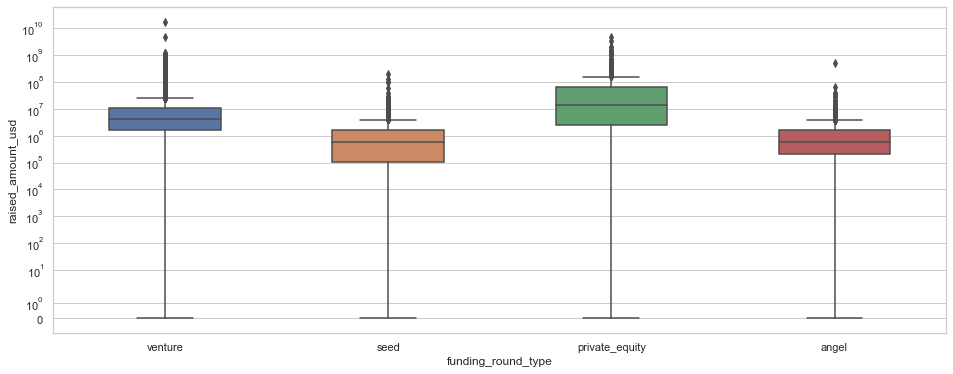

In [562]:
# drop the columns which is of no use for analysing the funding types
funding_analysis_frame = master_frame
funding_analysis_frame = funding_analysis_frame.drop(['state_code','funded_at', 'country_code'
                                                      ,'city', 'region','category_list', 'founded_at'
                                                      , 'funding_round_code']
                                                      , axis=1)
# As we are only interseted in these (venture, angel, seed, and private equity) four types of funding_type remove others funding types.
intersted_funding_types = ['venture', 'angel', 'seed', 'private_equity']
filtered_funding_analysis_frame = funding_analysis_frame[funding_analysis_frame['funding_round_type'].isin(intersted_funding_types)]     
#Visualize the box plot of this frame
plt.figure(100, figsize=(16, 6))
plt.yscale('symlog')
sns.boxplot(y='raised_amount_usd', 
                x='funding_round_type',
                data = filtered_funding_analysis_frame, width=0.5)

filtered_funding_analysis_frame = filtered_funding_analysis_frame.groupby('funding_round_type')['raised_amount_usd'].agg([min, max, sum, np.mean, np.median, 'count']).reset_index()
filtered_funding_analysis_frame = filtered_funding_analysis_frame.sort_values(by='mean', ascending=False)
filtered_funding_analysis_frame['mean'] = filtered_funding_analysis_frame['mean'].apply(lambda x: int(x))

# prob: Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity)
# solution:
# Venture:  11021030
# angel: 1125381
# seed: 952595
# private equity: 66118474

# prob: Based on the most representative investment amount calculated above, which investment type do you think is the most suitable for Spark Funds?
# since Spark Funds want to spend 5 to 15 million, 
given_funding_type = filtered_funding_analysis_frame[filtered_funding_analysis_frame['mean'].between(5000000, 15000000)].sort_values('mean', ascending=False)['funding_round_type']
#print('most sutiable funding type is ' + str(given_funding_type))
# solution: Venture

# ------------------------------second breakpoint----------------------------------------------------

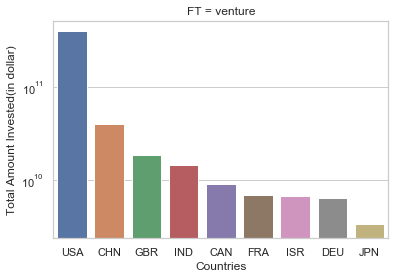

,country_code,min,max,sum,mean,count,Country
0,USA,0,17600000000,403437334911,1.126008e+07,35829,United States
1,GBR,0,500000000,18626180589,8.732387e+06,2133,United Kingdom
2,CAN,4697,165000000,8970011162,7.239718e+06,1239,Canada


In [531]:
# Country Analysis
given_funding_type = 'venture'
top9 = master_frame[master_frame['funding_round_type']== given_funding_type].groupby(['country_code'])['raised_amount_usd'].agg([min, max, sum, np.mean, 'count']).sort_values(by='sum', ascending=False).head(9).reset_index()

top3_english_speaking_frame = top9.merge(get_english_speaking_countries(), how='inner', on='country_code').head(3)
plt.yscale('log')
ax = sns.barplot(y='sum',
                x='country_code',
                data = top9)
ax.set(xlabel='Countries', ylabel="Total Amount Invested(in dollar)")
plt.title('FT = '+ given_funding_type)
plt.show()
# TODO: remove NAN from the values of master_frame
top_ctry = top3_english_speaking_frame['country_code'][0]
second_top_ctry = top3_english_speaking_frame['country_code'][1]
third_top_ctry = top3_english_speaking_frame['country_code'][2]
top3_english_speaking_frame

In [556]:
# Fetch mapping tables and remove unnecessary columns
mapping = pd.read_csv('mapping.csv', encoding='unicode_escape')
mapping['main_sector'] = mapping.iloc[:,1:].apply(lambda x: x.idxmax().strip(), axis=1)
mapping_ops = mapping[['category_list', 'main_sector']]
mapping_ops


,category_list,main_sector
0,NaN,Blanks
1,3D,Manufacturing
2,3D Printing,Manufacturing
3,3D Technology,Manufacturing
4,Accounting,"Social, Finance, Analytics, Advertising"
5,Active Lifestyle,Health
6,Ad Targeting,"Social, Finance, Analytics, Advertising"
7,Advanced Materials,Manufacturing
8,Adventure Travel,Automotive & Sports
9,Advertising,"Social, Finance, Analytics, Advertising"


                                               sum  count
main_sector                                              
Social, Finance, Analytics, Advertising  488378804     52
Manufacturing                            153618298     19
Others                                    66104000      7
News, Search and Messaging                46500000      4
Automotive & Sports                       17150000      2
                                              sum  count
main_sector                                             
Social, Finance, Analytics, Advertising  25646334      3
Manufacturing                            14529275      1
                                              sum  count
main_sector                                             
Manufacturing                            17770000      2
Social, Finance, Analytics, Advertising  12500000      2
Top heavily invested company in D1 for top sector Social, Finance, Analytics, Advertising is Xenon Arc
Top heavily invested company in D2 

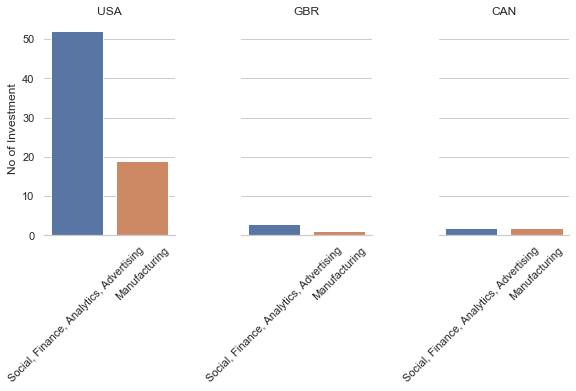

In [569]:
sector_analysis_frame = master_frame
given_funding_type = 'venture'
sector_analysis_frame['primary_sector'] = sector_analysis_frame['category_list'].apply(lambda x: str(x).split('|')[0])
sector_analysis_frame = sector_analysis_frame.merge(mapping_ops, how = 'inner', left_on='primary_sector', right_on='category_list')
sector_analysis_frame = sector_analysis_frame.drop(['category_list_y'], axis = 1)
sector_analysis_frame.head()
#filter for funding type FT and investment_range between (5000000, 15000000).
sector_analysis_frame = sector_analysis_frame.loc[(sector_analysis_frame['funding_round_type'] == given_funding_type) & (sector_analysis_frame['raised_amount_usd'].between(5000000, 15000000))]
D1 = sector_analysis_frame[(sector_analysis_frame['country_code'] == top_ctry)]
D2 = sector_analysis_frame[(sector_analysis_frame['country_code'] == second_top_ctry)]
D3 = sector_analysis_frame[(sector_analysis_frame['country_code'] == third_top_ctry)]

D1_investment = D1.groupby('main_sector')['raised_amount_usd'].agg([sum,'count']).sort_values(by='count', ascending=False)
top_sector_in_D1 = D1_investment.index[0]
print(D1_investment)
second_top_sector_in_D1 = D1_investment.index[1]
total_no_of_investment_for_D1 = D1_investment.sum()
D2_investment = D2.groupby('main_sector')['raised_amount_usd'].agg([sum,'count']).sort_values(by='count', ascending=False)
total_no_of_investment_for_D2 = D2_investment.sum()
top_sector_in_D2 = D2_investment.index[0]
print(D2_investment)
second_top_sector_in_D2 = D2_investment.index[1]
D3_investment = D3.groupby('main_sector')['raised_amount_usd'].agg([sum,'count']).sort_values(by='count', ascending=False)
total_no_of_investment_for_D3 = D3_investment.sum()
top_sector_in_D3 = D3_investment.index[0]
print(D3_investment)
second_top_sector_in_D3 = D3_investment.index[1]

print('Top heavily invested company in D1 for top sector '+ top_sector_in_D1 + ' is '+ D1[D1['main_sector']==top_sector_in_D1].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])
print('Top heavily invested company in D2 for top sector '+ top_sector_in_D2 +' is ' + D2[D2['main_sector']==top_sector_in_D2].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])
print('Top heavily invested company in D3 for top sector '+ top_sector_in_D3 + ' is ' + D2[D2['main_sector']==top_sector_in_D3].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])

print('Top heavily invested company in D1 for second top sector '+ second_top_sector_in_D1 + ' is '+ D1[D1['main_sector']==second_top_sector_in_D1].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])
print('Top heavily invested company in D2 for second top sector '+ second_top_sector_in_D2 + ' is '+ D2[D2['main_sector']==second_top_sector_in_D1].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])
print('Top heavily invested company in D3 for second top sector '+ second_top_sector_in_D3 + ' is '+ D3[D3['main_sector']==second_top_sector_in_D1].groupby('name')['raised_amount_usd'].agg([sum,'count']).sort_values(by='sum', ascending=False).index[0])

sector_analysis_frame = sector_analysis_frame.loc[(sector_analysis_frame['country_code'].isin([top_ctry, second_top_ctry, third_top_ctry ])) & (sector_analysis_frame['main_sector'].isin([top_sector_in_D1, top_sector_in_D2, top_sector_in_D3]))]
sector_analysis_frame = sector_analysis_frame.groupby(['country_code', 'main_sector'])['raised_amount_usd'].agg(['count']).sort_values(['country_code','count'], ascending=False).reset_index()

g = sns.catplot(x="main_sector", y="count", col="country_code",data=sector_analysis_frame, kind="bar",height=4, aspect=.7)
(g.set_axis_labels("", "No of Investment")
.set_titles("{col_name}")
.despine(left=True))
(g.set_xticklabels(rotation=45))